# Histopathological Cancer Detection

## Introduction

The Histopathological Cancer Detection aims to use cutting edge deep learning techniques to identify matastatic cancer in small images. The data supplied by Kaggle is a modified version of the PatchCamelyon dataset which contains more than 220,000 32x32 pixel images (in the .tif format) with a label of 0 for an example of a cell picture that does not contain a pixel of tumerous tissue whereas the 1 label is an example of a call p icture that does contain at least one pixel of tumerous tissue. The data is split into a train and test folder that contains the respective test and training images. Also included is a train_labels.csv file that provies the labels for the train dataset that can be used to train our CNN. 

For my implementation I will use a Convolutional Neural Network (CNN) using Pytorch to create an end to end model. The model will ouput the test id as well as a 0 or 1 label indicating the models prediction.  

## Imports

In [1]:
# standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch specific imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# sklearn specific imports
from sklearn.model_selection import train_test_split

# importing the custom CancerDataset model from the cancer_dataset.py file
from cancer_dataset import CancerDataset

In [2]:
# checking if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} :( ")

Using device: cpu :( 


### Data imports

In [3]:
# loading the directory to both the train and test data
# as well as reading in the labels dataset that I will visualize in the EDA section
train_dir = '/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/train/'
test_dir =  '/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/test/'
labels = pd.read_csv('/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/train_labels.csv')

In [4]:
# Append .tif extension to image IDs to allow for easier loading
labels['id'] = labels['id'] + '.tif'

## EDA

As part of the EDA process, I will start by visualizing the training_labels file. I will then build a basic histogram of the count of images that contains a cancer cell vs a count of the number of images that does not contain a cancer cell. I will then visualize 50 images from our train_labels file that contains a cancer cell and will separately visualize 50 images that does not contain a cancer cell. This will be the extent of the EDA performed as there is a limited number of columns to visualize in this dataset.

By doing this exploratory data analysis, both the creator and the viewer of the notebook will gain a better understanding of the structure and characteristics of the data that will be modeled later on in the notebook. 

In [5]:
# here is what the data from our validation set looks like
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

In [6]:
print(f'The number of data points is: {len(labels)}')

The number of datapoints: 220025


In [7]:
# here is the count of cancerous and non-cancerous values present in our validation set
labels.value_counts()

id                                            label
00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif  1        1
aafa66be401644d911bf216e6e3d3e7970f55194.tif  1        1
aafb5b379c54b029f395eb664e052653a8d5c5db.tif  1        1
aafbdfd08f338fa8eb59e76e4e5a026e81b1915b.tif  0        1
aafcecc71fcc22a018c7966f629133dd6ad93ebd.tif  1        1
                                                      ..
55b8cb133f5755df024ec0c46bc5579c9178bed1.tif  0        1
55b8f6c58e3d6e719866cf76c0d5bc22840ad188.tif  0        1
55b9081b80241e43db5d314e9c3327d8fc8bb68f.tif  1        1
55b94ae30d2025a815c4729a97acdbd06f7398e4.tif  1        1
ffffe55093358954f38bba4c35b6aa0ece86177c.tif  0        1
Name: count, Length: 220025, dtype: int64

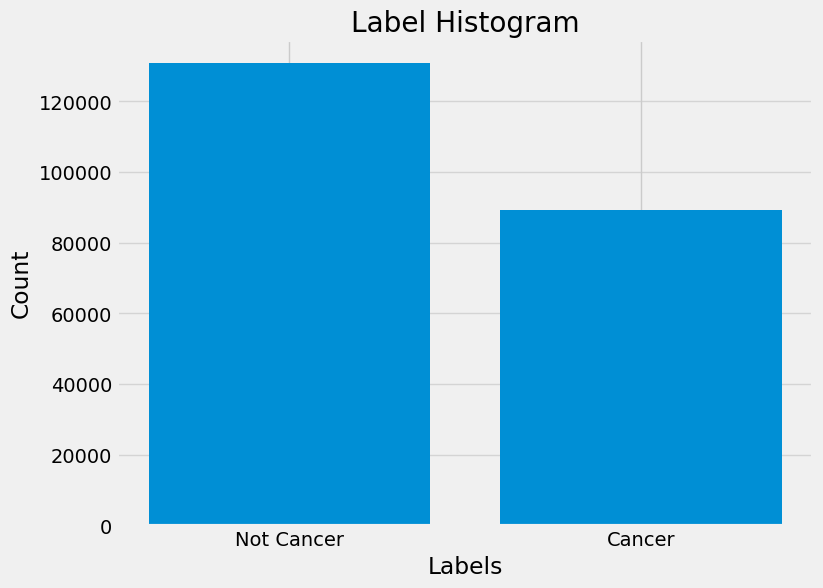

In [8]:
# the value counts call from above visualized
# there are quite a few more non-cancer samples than cancer samples
plt.style.use('fivethirtyeight')
plt.figure(figsize = (8, 6))
plt.hist(labels['label'], bins = [-0.5, .5, 1.5], rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Cancer', 'Cancer'])
plt.title('Label Histogram')
plt.grid(axis = 'y', alpha = 0.75)
plt.show()

### Visualize Images

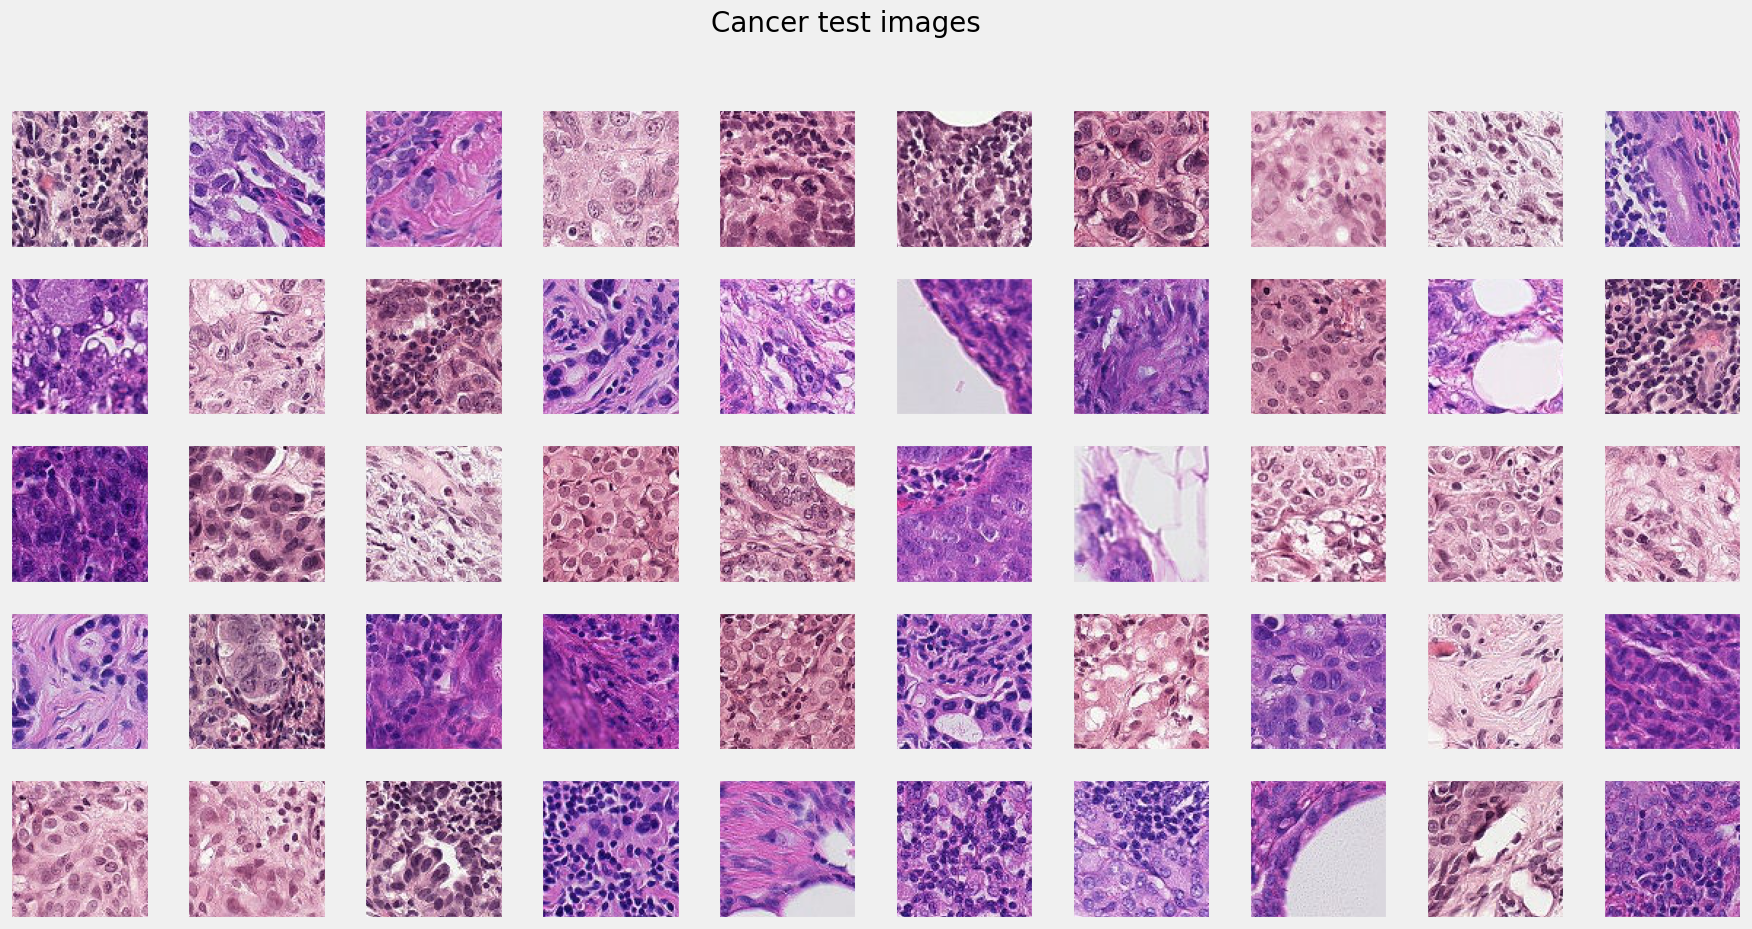

In [9]:
# here I am visualizing 50 images that contain cancer cells from the label .csv file
fig, ax = plt.subplots(5, 10, figsize = (20, 10))


for n in range(5):
    for m in range(10):
        img_id = np.random.choice(labels[labels.label==1].id, size=50, replace=False)[m + n * 10]
        image = plt.imread(train_dir + img_id)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].tick_params(labelbottom = False, labelleft = False)

fig.suptitle('Cancer test images', fontsize=20)
plt.show()

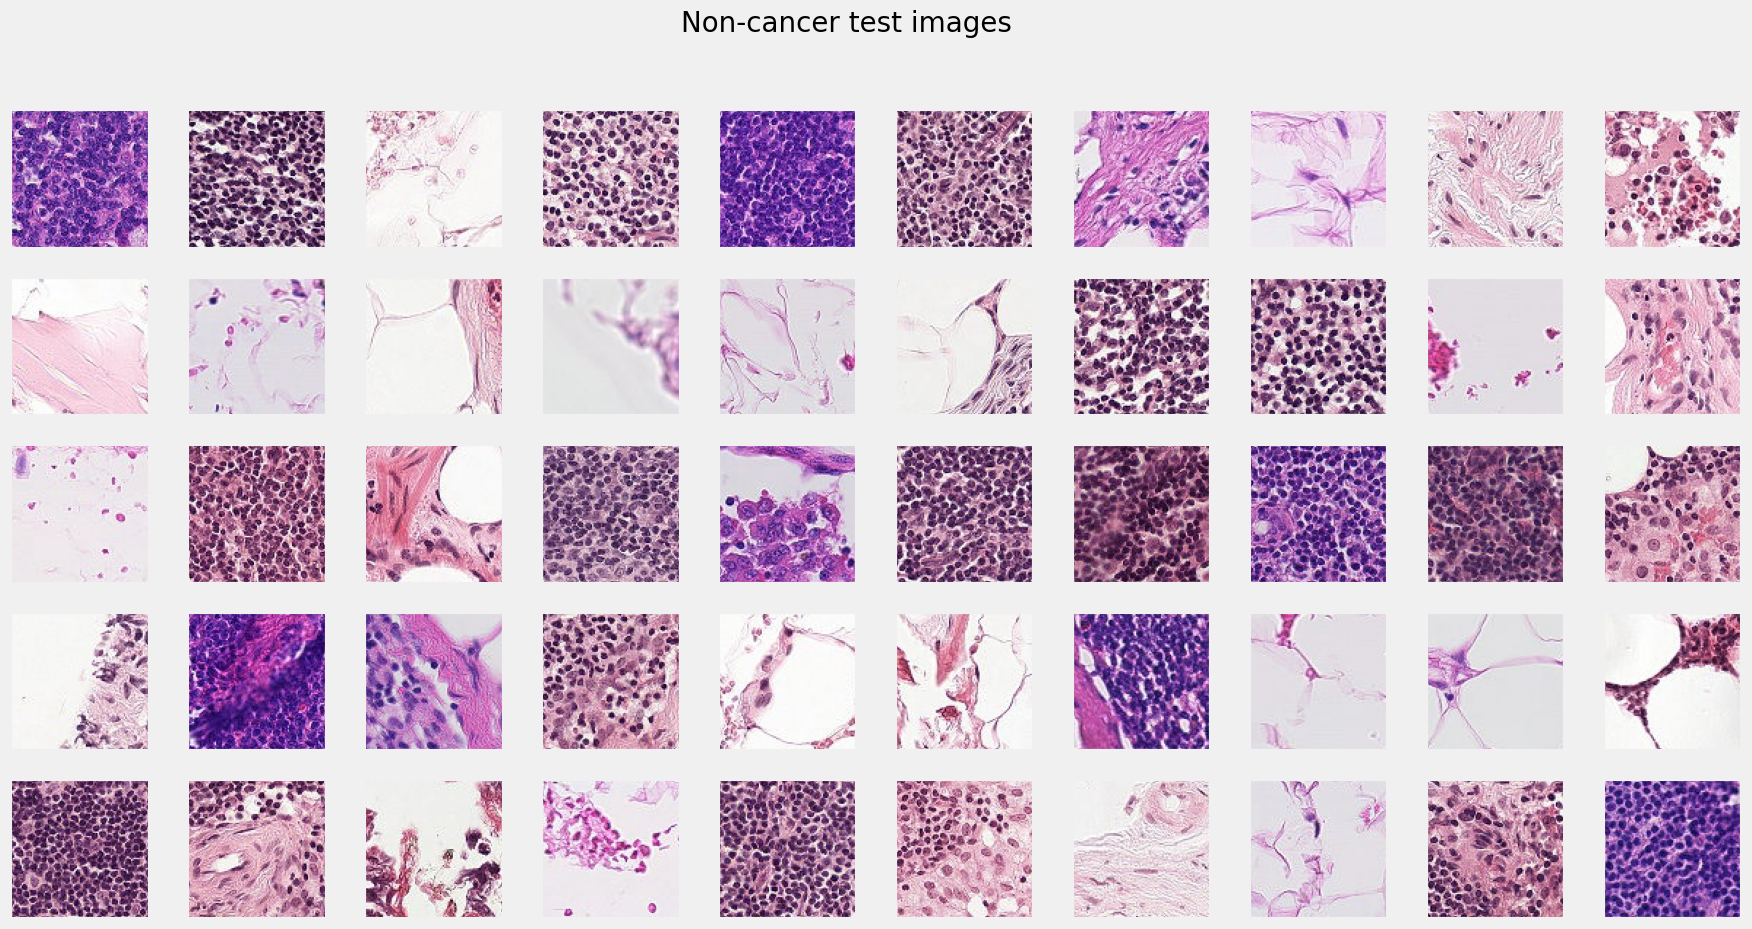

In [10]:
# here I am visualizing 50 images that do not contain cancer cells from the label .csv file
fig, ax = plt.subplots(5, 10, figsize = (20, 10))


for n in range(5):
    for m in range(10):
        img_id = np.random.choice(labels[labels.label==0].id, size=50, replace=False)[m + n * 10]
        image = plt.imread(train_dir + img_id)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].tick_params(labelbottom = False, labelleft = False)

fig.suptitle('Non-cancer test images', fontsize=20)
plt.show()

## Train Test Split

In [13]:
# limiting the data from 220,000 rows to 140,000 rows to allow for the model below to train faster
sample_size = 140000
labels = labels.iloc[:sample_size]

# creating the train and validation dataframes using sklearn's train_test_split
# also leaving 15% of the data for our test set and balancing the number of cancer vs. non-cancer images
train_df, val_df = train_test_split(labels, stratify = labels['label'], test_size = 0.15, random_state = 42)

In [14]:
print(f'The number of values in the training set is: {len(train_df)} and the number of values in the validation set is: {len(val_df)}')

The number of values in the training set is: 119000 and the number of values in the validation set is: 21000


## Data Augumentation

Data augumentation and normalization are critcal steps in deep learning. By flipping, rotating, translating, and zooming the pictures that the model will be trained on, the model learns additional features that it wouldn't have had exposure to if the augumentation did not happen. There is also an overfitting aspect to consider as well. If the effective size of the training data is increased due to the different variants of the image being passed to the model, the model is encouraged to learn general patterns in the data instead of the model learning specific examples. For these two reasons, data augumentation will be included in the deep learning model implementation. 

In [15]:
# creating the transformation that will take place for each type of data. 
# here, we are defining different augumentation for the train, val, and test datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Create DataLoader

Creating a DataLoader class facilitates data handling and managing in deep learning applications. The DataLoader class creates batches in the dataset that essentially groups multiple samples together which is more computationally efficient. If using a GPU, it also allows for parallel data loading which increases the speed at which the data is loaded. Overall, the DataLoader class is helpful in loading, preprocessing, and batching and can be incredibly helpful in managing large datasets such as the cancer dataset we are working with.

In [16]:
# reading in the CancerDataset custom package from the cancer_dataset.py file located in this repo
# this package defines dataset specific functions to upload the data
train_dataset = CancerDataset(train_df, train_dir, transform = data_transforms['train'], mode = 'train')
val_dataset = CancerDataset(val_df, train_dir, transform = data_transforms['val'], mode = 'val')

In [18]:
# passing the train_dataset and val_dataset from above to the DataLoader class
# with the batch size set to 64 and the number of workers set to 4 to allow for parallel processing
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers = 4)

## CNN Model

The custom Convolutional Neural Network (CNN) was designed for the specific task of taking in the 32x32 images and outputting the binary cancerous or non-cancerous output. I decided to use a four layer technique with ReLu normalization and MaxPool pooling. The individual layers were then fully connecte that would be passed through the sigmoid function defined in the second code block below. The sigmoid activation function was particularly important because it is fit to output the binary response we were looking for. This was an obvious choice to use in the model.  

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(256)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Initialize Model, Loss Function, and Optimizer

## Train Function

Below is a custom function that will be passed our model, the criteria, optimizer, scheduler and for a given epoch, will output the running model loss for both the training and validation set. It will also build a 'history' variable that will hold the training loss and accuracy after each epoch. The criterion, optimizer, and scheduler will be called in the cell below.

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 15):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1} / {num_epochs}')
        print('-' * 20)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                val_corrects += torch.sum(preds == labels)

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Validation loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}\n')
    
    return history

## Model Training

Here is where the model training is actually occuring. We will creat our CNN model, define our criterion loss to be binary cross entropy, set our optimizer to the Adam optimizer with a learning rate of 0.0001, and set the scheduler to help adjust the learning rate dynamically after every 7 epochs in our example. With the model, criterion, optimizer, and the scheduler defined, we can finally call the train_model function with our inputs from above to kick off testing.

In my case, the model took about 4.5 hours to train and achieved an overall accuracy score of .8987 on our validation set.

In [21]:
if __name__ == '__main__':
    model = CNNModel().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    history = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 1 / 15
--------------------
Training loss: 0.4959, Accuracy: 0.7689
Validation loss: 0.4062, Accuracy: 0.8164

Epoch 2 / 15
--------------------
Training loss: 0.4554, Accuracy: 0.7927
Validation loss: 0.4113, Accuracy: 0.8142

Epoch 3 / 15
--------------------
Training loss: 0.4360, Accuracy: 0.8032
Validation loss: 0.3910, Accuracy: 0.8239

Epoch 4 / 15
--------------------
Training loss: 0.4170, Accuracy: 0.8137
Validation loss: 0.3294, Accuracy: 0.8540

Epoch 5 / 15
--------------------
Training loss: 0.3995, Accuracy: 0.8235
Validation loss: 0.3247, Accuracy: 0.8598

Epoch 6 / 15
--------------------
Training loss: 0.3826, Accuracy: 0.8324
Validation loss: 0.3044, Accuracy: 0.8704

Epoch 7 / 15
--------------------
Training loss: 0.3734, Accuracy: 0.8371
Validation loss: 0.2925, Accuracy: 0.8780

Epoch 8 / 15
--------------------
Training loss: 0.3483, Accuracy: 0.8497
Validation loss: 0.2645, Accuracy: 0.8896

Epoch 9 / 15
--------------------
Training loss: 0.3437, Accurac

## Evaluation

In the evaluation phase, I observed steady improvement in both the accuracy and loss across both the training and validation loss and accuracy. In the earlier epochs, the model converged quicker whereas in the later epochs, the training accuracy and loss were only moderately effected. This slowdown in accuracy metrics indicates that our model is not overfit and is able to predict on both datasets quite well. The visualization of the training and validation loss/accuracy below graphically represents this slowdown. I found it very interesting to see that the accuracy in the validation set, the accuracy actually decreased from epoch 2 to 3. This indicates that a slightly lower learning rate could possibly achieve a higher overall accuracy.  

In [22]:
val_loss, val_acc = history['val_loss'][-1], history['val_acc'][-1]
print(f'Validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}')

Validation loss: 0.2457, validation accuracy: 0.8987


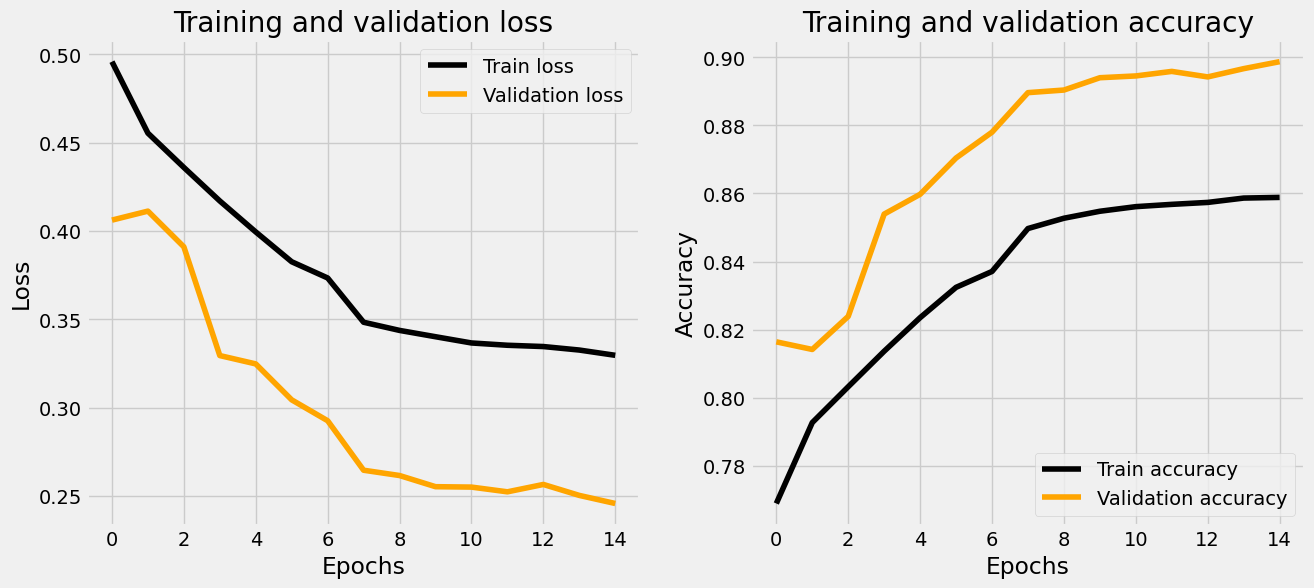

In [23]:
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label = 'Train loss', color = 'black')
plt.plot(history['val_loss'], label = 'Validation loss', color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label = 'Train accuracy', color = 'black')
plt.plot(history['val_acc'], label = 'Validation accuracy', color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy')

plt.show()

## Prdictions and Kaggle Test Submission

Finally, to submit our predictions to Kaggle we had to create a new test_dataset and test_loader using the same parameters from above. Then, a new variable 'predictions' was created to collect the models binary outputs. With the outputs, I had to conduct a bit of DataFrame manipulation to match the format in the sample_submission.csv and finally placed the final outputs into a 'submission.csv' file that will be uploaded to Kaggle. With my overall accuracy score of .8987 on the validation set, I'm hoping for a test accuracy in the mid 80%'s which would score quite well on the leaderboards. The first 5 rows of the final 'submission.csv' output can be visualized below.

In [24]:
test_images = [f for f in os.listdir(test_dir) if f.endswith('tif')]
test_df = pd.DataFrame({'id': test_images})

test_dataset = CancerDataset(test_df, test_dir, transform = data_transforms['test'], mode = 'test')
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4)

model.eval()
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze(1)
        preds = (outputs > 0.5).float()
        predictions.extend(preds.cpu().numpy())

In [26]:
submission = pd.DataFrame({'id': test_images, 'label': predictions})
submission['id'] = submission['id'].str.replace('.tif', '')
submission['label'] = submission['label'].astype(int)
submission.to_csv('/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/submission.csv', index = False)
print(submission.head())

                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      0
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0


## Conclusion

In conclusion, the task of detecting cancerous cells in histopathological images was no small task. It took very a very precise deep learning architecture to achieve the required outcomes. The process that was followed was to import the required packages, explore some of the training data, pre-process and augment the data using the the transformers class from sklearn and the DataLoaders class, building the model layer by layer, training the label with 15 epochs, and finally evaluating the models performance and preddiction generation which was submitted through the Kaggle competition homepage. Each step in the process was critical to achieve the overall accuracy of .8987.

Deep learning techniques such as CNN's are very promising in applications such as cancer detection that has saved numerous lives and will continue to do so as deep learning architecture and models become more and more robust. It was exciting (and also a bit of a struggle) to work through an entire end to end example throughout this notebook. There are certainly other applications for deep learning techniques such as this in NLP research, business optimization, and data generation to name a few.

I learned a great deal about how to conduct an end to end deep learning project and I hope others can achive the same outcome that I did.

### Challenges

There were many challenges that were overcome throughout the creation of this notebook. For example, handling the data imbalance in the initial data exploration phase. This was resolved by stratifying the data in our call to train_test_split by using the stratify method that allowed for the same number of cancerous and non-cancerous samples to be present in both the training dataframe and the validation dataframe. This certainly helped improve our models ability to detect both classes.

Another challenge throughout this notebook was getting the CNN architecture correct. At first, I was very lost in what was happening in the different layers and how they were able to connect. After referencing some additional sample notebooks, I was able to figure it out but it certainly wasn't clear to me at first. Since this was the first real end to end deep learning model I have created, the intricate steps required to even achieve an output was hard for me. It was helpful to reference additional online material and read the PyTorch docs.

### Future Work

In the future, the following points could be addressed to achieve an even more impressive accuracy:
- Hyperparameter tuning: although some hyperparameter tuning was attempted, further tuning hyperparameters such as learning rate and batch size could result in a higher overall accuracy.
- Transfer Learning: Implementing transfer learning by leveraging pre-trained models could grealty enhance my models performance. I noticed many examples of transfer learning in the shared notebook in the Kaggle competitions homepage that received almost perfect results.
- Ensemble methods: Using ensemble methods to combine predictions from multiple models could also result in a higher overall accuracy. For example, creating a custom model paired with a pre-trained model would be very interesting architecture to research further.